In [20]:
%matplotlib inline
import pymc3 as pm
from theano import shared
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)

#### Code 5.1

In [21]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [22]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '3226' (I am process '6886')


Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bA
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 0.9 sec

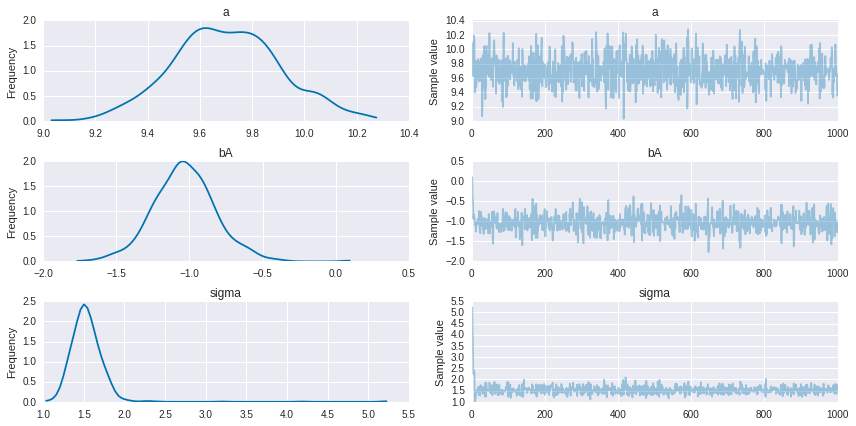

In [23]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

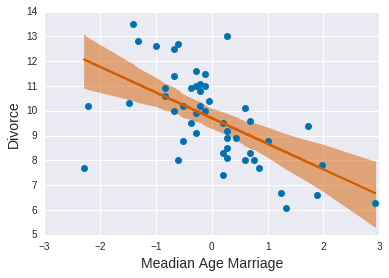

In [24]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'bo')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

##### Code 5.3

In [25]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [26]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bA
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 1.2 sec

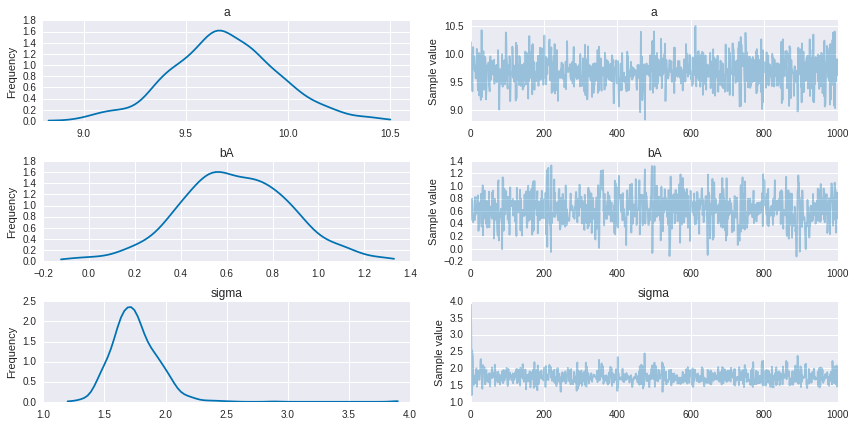

In [27]:
pm.traceplot(trace_5_2, varnames);

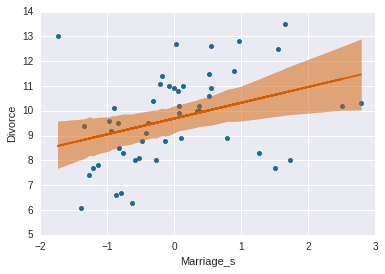

In [28]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5);

#### Code 5.4

In [29]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bA
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 1.3 sec

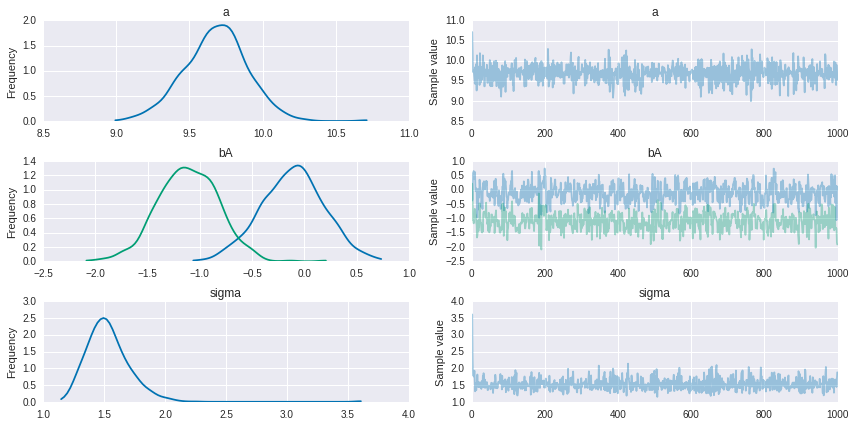

In [30]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [31]:
pm.df_summary(trace_5_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,9.681393,0.215829,0.007503,9.252797,10.088186
bA__0,-0.111564,0.302324,0.013432,-0.774456,0.412757
bA__1,-1.111631,0.290419,0.013109,-1.615204,-0.493484
sigma,1.533679,0.191154,0.008296,1.250715,1.888050


#### Code 5.5

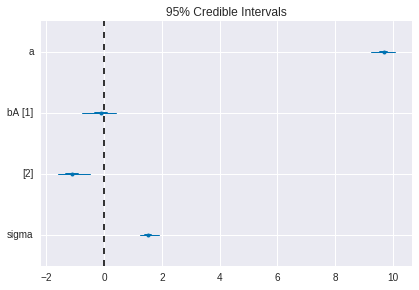

In [32]:
pm.forestplot(trace_5_3, varnames);

#### Code 5.6

In [33]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to b
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 1.6 sec

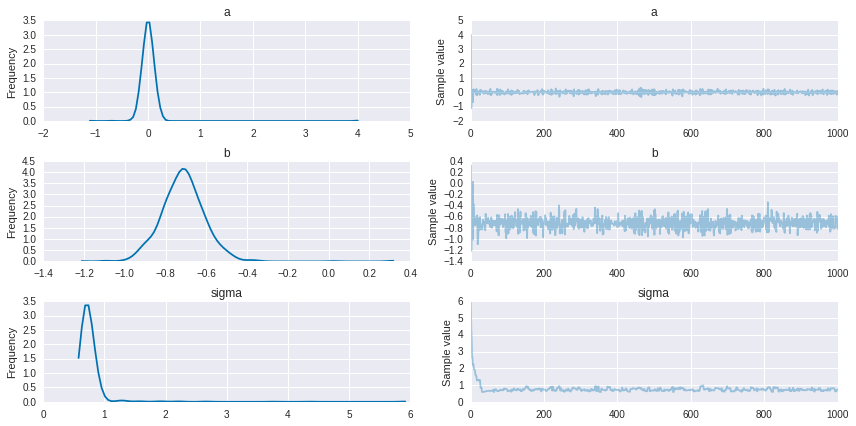

In [34]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [35]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

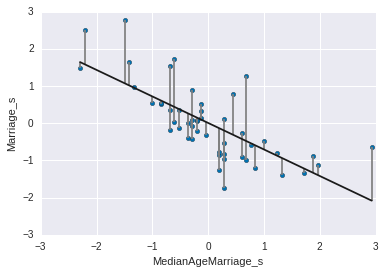

In [36]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

#### Code 5.9

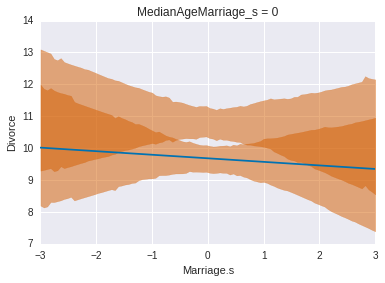

In [37]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

#### Code 5.10

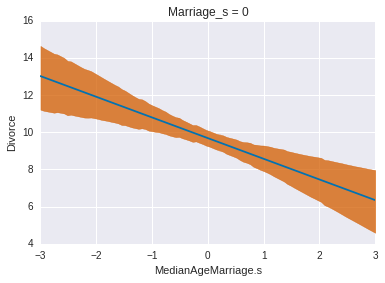

In [38]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

#### Code 5.11

In [39]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

#### Code 5.12

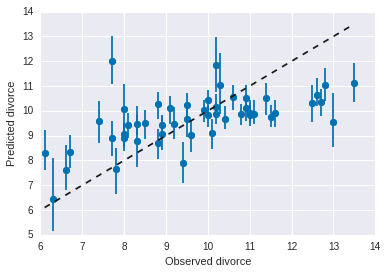

In [40]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='bo')
plt.plot(d.Divorce, divorce_pred.mean(0), 'bo')

plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

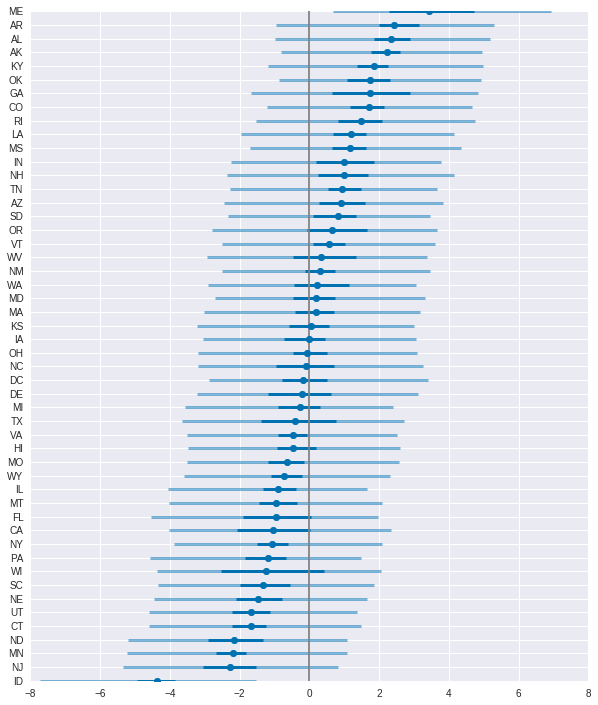

In [41]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='bo',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='bo', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

#### Code 5.15

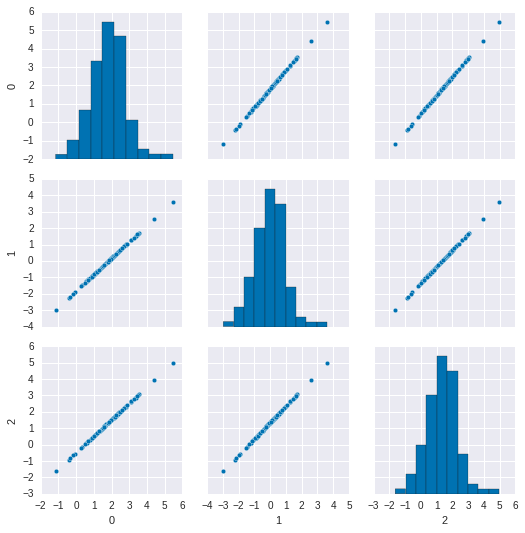

In [42]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.16

In [43]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.17 to 5.20

In [44]:
dcc = d.dropna().copy()

In [45]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bn
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 15.1 sec

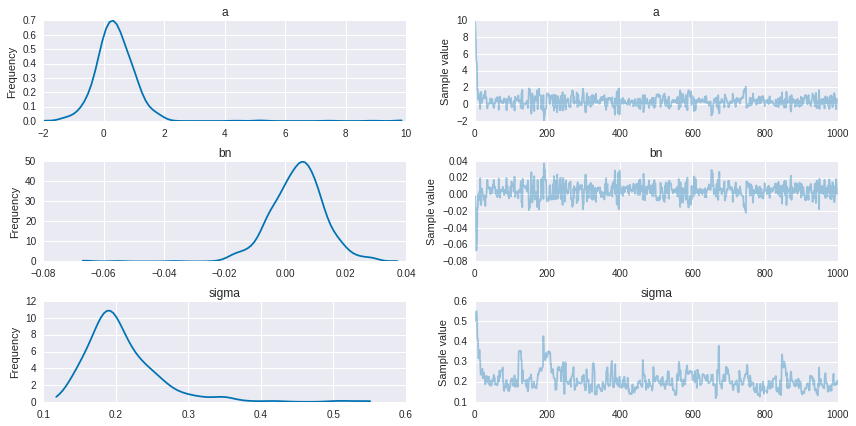

In [46]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [47]:
pm.df_summary(trace_5_5, varnames).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.411,0.829,0.058,-0.819,1.597
bn,0.004,0.009,0.001,-0.015,0.020
sigma,0.209,0.053,0.005,0.132,0.308


#### Code 5.22

In [48]:
trace_5_5['bn'].mean() * (76 - 55)

0.085693940277165689

#### Code 5.23

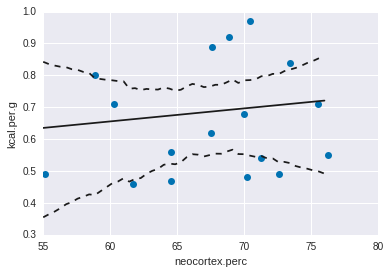

In [49]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'bo')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.24

In [50]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [51]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bn
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 6.1 sec

In [52]:
pm.df_summary(trace_5_6, varnames).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.74,0.55,0.03,0.57,0.85
bn,-0.03,0.10,0.00,-0.09,0.02
sigma,0.21,0.11,0.01,0.12,0.29


#### Code 5.26

In [53]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bn
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 17.6 sec

In [54]:
pm.df_summary(trace_5_7, varnames).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,-1.01,1.05,0.09,-2.35,0.42
bn__0,0.03,0.01,0.00,0.01,0.05
bn__1,-0.10,0.06,0.00,-0.15,-0.03
sigma,0.16,0.06,0.01,0.10,0.22


#### Code 5.27

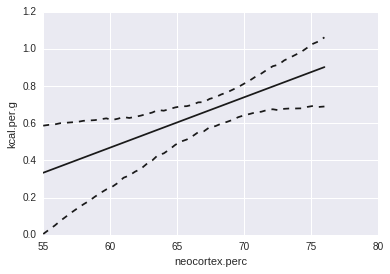

In [55]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

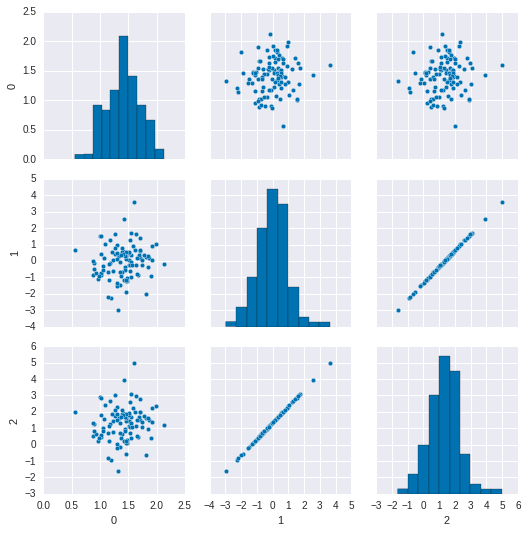

In [56]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [57]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
d = pd.DataFrame([height,leg_left,leg_right])
d

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,9.530513,11.472144,8.786442,8.647274,11.010450,11.930969,9.945878,11.182189,3.851192,9.688278,...,11.663105,6.647587,10.432364,7.621240,10.869310,11.911790,9.779256,12.307639,7.856517,9.257651
1,7.347820,9.643798,6.435279,6.542273,6.220376,8.791875,7.830395,5.847102,2.680122,7.730323,...,5.886159,3.710465,4.303186,6.496605,5.525973,6.423678,4.387668,7.050666,4.660232,5.922833
2,7.371520,9.738870,6.472839,6.569604,6.215074,8.797925,7.865050,5.833134,2.709511,7.708935,...,5.848063,3.695227,4.252744,6.490626,5.499786,6.447654,4.410939,7.052610,4.626174,5.999011


#### Code 5.30

In [58]:
with pm.Model() as m5_8:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    br = pm.Normal('br',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_8 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bl
Assigned NUTS to br
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 47.0 sec

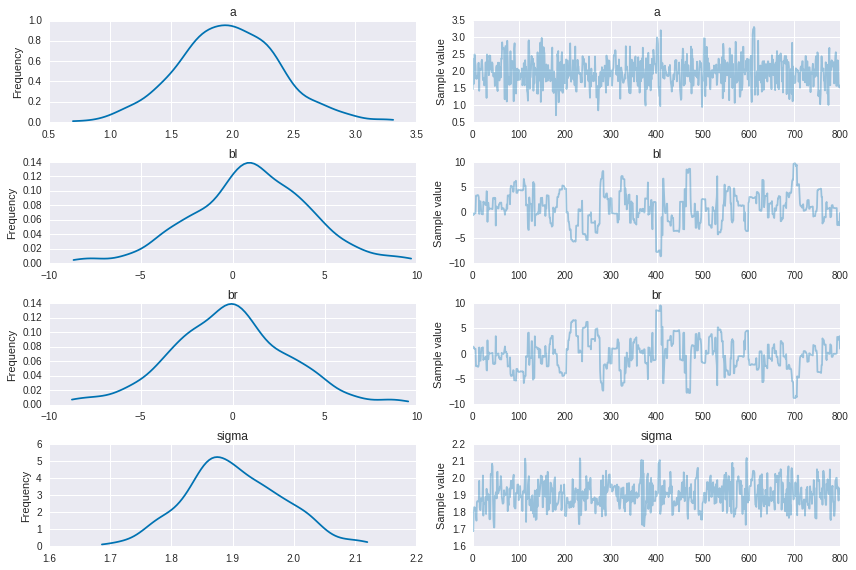

In [59]:
varnames=['a', 'bl', 'br', 'sigma']
chain=trace_5_8[200:]
pm.traceplot(chain, varnames);

#### Code 5.31

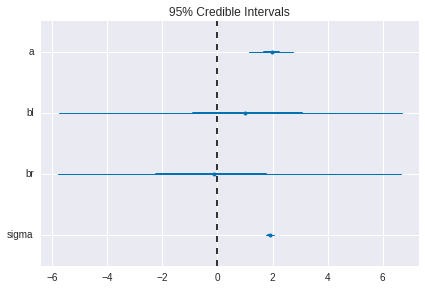

In [60]:
pm.forestplot(chain, varnames);

#### Code 5.32

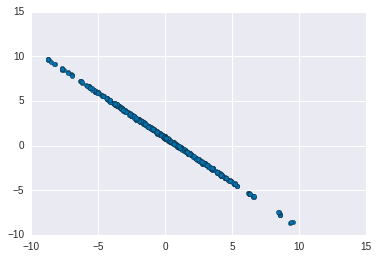

In [61]:
plt.scatter(chain['br'], chain['bl']);

#### Code 5.33

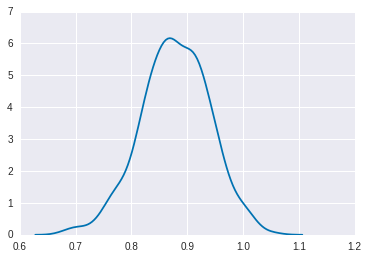

In [62]:
sum_blbr = chain['br']+chain['bl']
sns.kdeplot(sum_blbr);

#### Code 5.34

In [63]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_9 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bl
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 3.8 sec

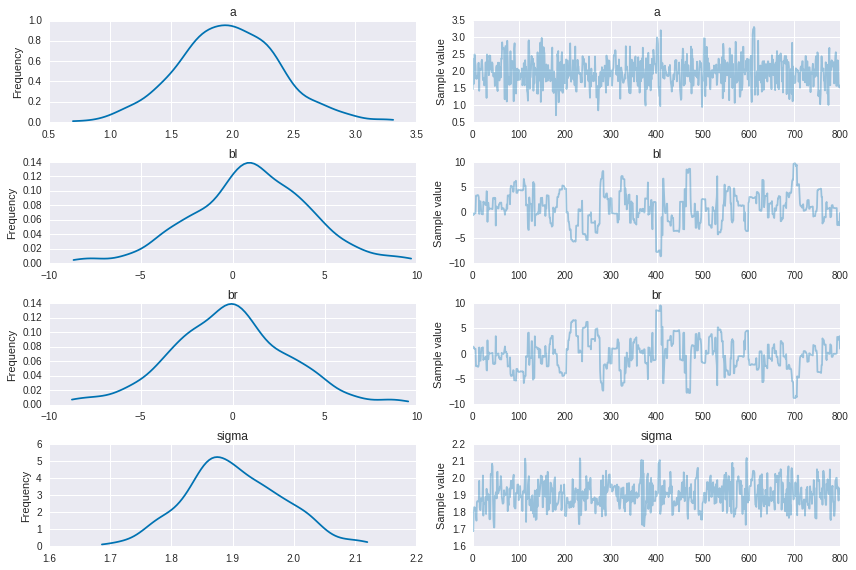

In [64]:
chain_1 = trace_5_9[200:]
varnames_1= ['bl', 'sigma', 'a']
pm.traceplot(chain, varnames);

#### Code 5.35

In [65]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.36

In [66]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bf
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 4.6 sec

In [67]:
varnames=['a', 'bf', 'sigma']
pm.df_summary(trace_5_10, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.305849,0.068036,0.004406,0.199605,0.382653
bf,0.009945,0.001838,0.000089,0.007816,0.012478
sigma,0.119448,0.336920,0.032287,0.052979,0.115378


In [68]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bl
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 6.6 sec

In [69]:
varnames=['a', 'bl', 'sigma']
pm.df_summary(trace_5_11, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.153608,0.127884,0.011424,1.059394,1.265902
bl,-0.010304,0.002623,0.000238,-0.012624,-0.008756
sigma,0.094026,0.257639,0.023912,0.050022,0.091070


#### Code 5.37

In [70]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bf
Assigned NUTS to bl
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 10.4 sec

In [71]:
varnames=['a', 'bf', 'bl', 'sigma']
chain_5_12 =  trace_5_12[200:]
pm.df_summary(chain_5_12, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.034304,0.247848,0.016349,0.510780,1.482953
bf,0.001646,0.002996,0.000193,-0.003353,0.008342
bl,-0.009036,0.003004,0.000197,-0.014719,-0.003030
sigma,0.069688,0.011015,0.000800,0.050921,0.093572


#### Code 5.38

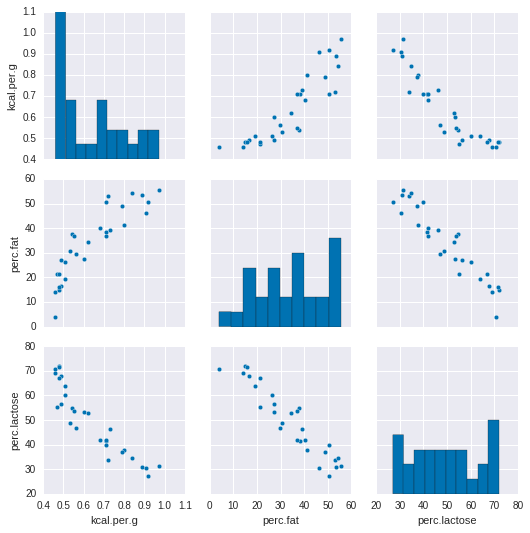

In [72]:
df=milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

In [73]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.2
IPython 4.1.2
PyMC3 3.0
NumPy 1.10.4
Pandas 0.18.0
SciPy 0.17.0
Matplotlib 1.5.1
Seaborn 0.7.0

